In [1]:
import matplotlib.pyplot as plt
import rosbag_pandas

%matplotlib inline

In [3]:
from collections import namedtuple
Coords = namedtuple("Coords", "x y")

In [19]:
from record_bagfiles import ROSBAG_TOPICS
ROSBAG_TOPICS.remove("/ardrone/past_image")
ROSBAG_TOPICS.remove("/ardrone/slow_image_raw")

In [14]:
def pad_bag(df):
    df.fillna(method="pad", inplace=True)
    df.fillna(method="backfill", inplace=True)

In [16]:
def load_bag(filename, include=ROSBAG_TOPICS):
    df = rosbag_pandas.bag_to_dataframe(filename, include=include)
    pad_bag(df)
    return df

In [101]:
def plot_xy(df, x="x", y="y", s=None, c=None, cmap="viridis", alpha=1, show_cbar=True, label=None):
    """
    Coords in real frame. +x is towards doors, +y is away from table.
    
    """
    if s is not None:
        s = df[s]*25
    if c is not None:
        label = c
        c = df[c]
    else:
        c = df.index
        label="time"
    
    p_init = Coords(df[x][0], df[y][0])
    plt.scatter(-df[x], -df[y], s=s, c=c, cmap=cmap, alpha=alpha)
    if show_cbar:
        plt.colorbar(label=label)
    plt.axis("equal")

In [125]:
def plot_targets(df, x="x", y="y", target_coords=(Coords(-1, 3.6), Coords(-2, 1.6)), target_color="r"):
    p_init = Coords(df[x][0], df[y][0])
    p_final = Coords(df[x][-1], df[y][-1])
    plt.scatter(-p_init.x, -p_init.y, marker=(5, 1), s=100, c="orange")
    for coord in target_coords:
        plt.scatter(coord.x - p_init.x, coord.y - p_init.y, marker=(5, 1), s=100, c="m")    
    plt.scatter(-p_final.x, -p_final.y, marker=(3, 0), s=100, c="r")
    plt.axis("equal")

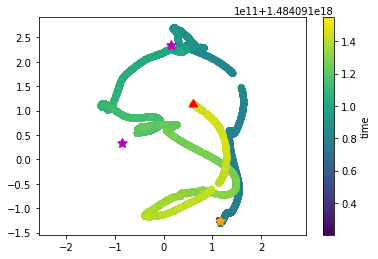

In [126]:
plot_xy(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

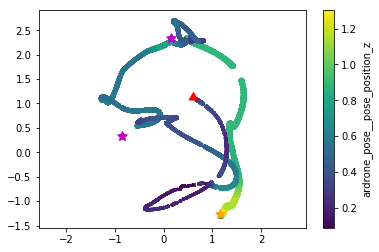

In [127]:
plot_xy(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

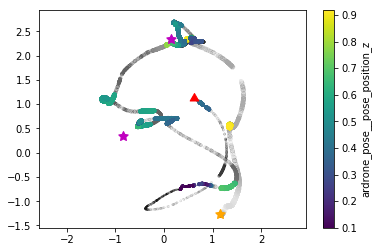

In [128]:
plot_xy(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z", cmap="gray", alpha=0.002, show_cbar=False)
plot_xy(df0[df0.ardrone_navdata__state==4], "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")

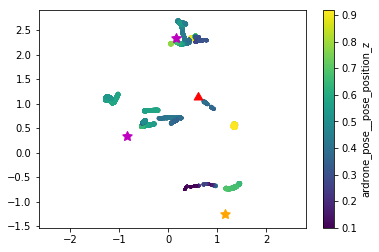

In [129]:
plot_xy(df0[df0.ardrone_navdata__state==4], "ardrone_ground_pose__x", "ardrone_ground_pose__y",
        s="ardrone_pose__pose_position_z", c="ardrone_pose__pose_position_z")
plot_targets(df0, "ardrone_ground_pose__x", "ardrone_ground_pose__y")